In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdg
import yaml
import pickle
import uncertainties.unumpy as unp

from scripts.hammer_reweight import run_BtoXcLepNu_hammer
import samples, database, scripts

from typing import Dict, List, Optional, Tuple, Union
from hammer.hammerlib import FourMomentum, Hammer, Particle, Process, WTerm, version
from importlib_resources import files
import xulnu.db.form_factors.xclnu


from uncertainties import ufloat, correlated_values_norm, correlated_values, covariance_matrix, correlation_matrix
from iminuit import Minuit

In [12]:
# Load data frame
df = pd.read_parquet(files(samples).joinpath('D0stCh_Dpi_BLR.pq'))
# Create variable w if needed
df['w'] = (pdg.get(511).Mass()**2 + pdg.get(10411).Mass()**2 - df['genq2']) / (2 * pdg.get(511).Mass() * pdg.get(10411).Mass())
print(len(df))

100000


In [13]:
with open(files(database).joinpath('dict_BtoD0stEllNu.yaml'), 'rb') as f:
    dict_dstst = yaml.load(f, Loader=yaml.FullLoader)

In [14]:
dict_dstst

{'BtoD0stEllNu_isgw2': {'Xc_string': 'D**0*',
  'lep_string': 'Ell',
  'model': 'ISGW2',
  'num_params': 0},
 'BtoD0stEllNu_new': {'Xc_string': 'D**0*',
  'corrmat': [[1.0, -0.95, -0.44], [-0.95, 1.0, 0.61], [-0.44, 0.61, 1.0]],
  'lep_string': 'Ell',
  'model': 'BLR',
  'name_0': 'zt1',
  'name_1': 'ztp',
  'name_2': 'zeta1',
  'num_params': 3,
  'param_0': 0.7,
  'param_1': 0.2,
  'param_2': 0.6,
  'param_initializer': '{zt1: %f, ztp: %f, zeta1: %f, mb: 4.71, mc: 1.31}',
  'uncert_0': 0.21,
  'uncert_1': 1.4,
  'uncert_2': 0.3}}

In [15]:
def prediction_shape(x):
    for i, val in enumerate(x):
        dict_dstst['BtoD0stEllNu_new'][f'param_{i}'] = val
    ratedict = run_BtoXcLepNu_hammer(df, dict_dstst, verbose=False)
    bins=[1.00, 1.08, 1.16, 1.24, 1.32, 1.40]
    output_shape, _ = np.histogram(
        df['w'],
        weights=df['FF_weight_BtoDstst0st_BLR_norm'],
        bins=bins, # TODO: binning will depend on data so add this as a function parameter
    )
    output_shape /= np.sum(output_shape)
    return np.array(output_shape)

In [16]:
prediction_shape([0.70, 0.2, 0.6])

array([0.02008064, 0.09784186, 0.23542478, 0.43595105, 0.21070167])

Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11


In [17]:
# Create some data
values = np.array([
    ufloat(0.05, 0.02),
    ufloat(0.02, 0.05),
    ufloat(0.30, 0.08),
    ufloat(0.30, 0.09),
    ufloat(0.33, 0.13),
])
central = np.array([cv.nominal_value for cv in values])
errors = np.array([cv.std_dev for cv in values])
corr_mat = np.array([
       [ 1, 0, 0, 0, 0],
       [ 0, 1, 0, 0, 0],
       [ 0, 0, 1, 0, 0,],
       [ 0, 0, 0, 1, 0,],
       [ 0, 0, 0, 0, 1,],
])

cov_mat = np.outer(errors, errors) * corr_mat

val_correlated = correlated_values(central, cov_mat)

In [18]:
data_shape_covariance_fit = np.array(covariance_matrix(val_correlated))
shape_Cinv = np.linalg.inv(data_shape_covariance_fit)  # Just do it once because it is computational expensive
data_shape_fit = np.array(unp.nominal_values(val_correlated))
print(shape_Cinv)

[[2500.            0.            0.            0.            0.        ]
 [   0.          400.            0.            0.            0.        ]
 [   0.            0.          156.25          0.            0.        ]
 [   0.            0.            0.          123.45679012    0.        ]
 [   0.            0.            0.            0.           59.17159763]]


In [19]:
def chi2_blr_broad(zt1, ztp, zeta1): # Vcb?
    x = np.array([zt1, ztp, zeta1])
    # print(x)
    
    # Useful variabales here:
    # data_shape_fit
    # shape_Cinv
    # data_norm_fit
    # hA1_2014

    prediction = prediction_shape(x)
    # print(prediction)

    delta = prediction - data_shape_fit
    # print(delta)
    chi2_shape = delta.transpose() @ shape_Cinv @ delta
    
    # chi2_norm = (data_norm_fit.n - prediction_rate(x)) ** 2 / data_norm_fit.s **2
    
    # chi2_lattice = (hA1_2014.n - prediction_form_factor(x)) ** 2 / hA1_2014.s ** 2

    return chi2_shape # chi2_norm + chi2_lattice +

In [20]:
chi2_blr_broad(0.70, 0.2, 0.6)

8.437166911234373

Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11


In [ ]:
m = Minuit(
    chi2_blr_broad,
    zt1=0.70,
    ztp=0.2,
    zeta1=0.6,
)

m.simplex()
m.migrad()
m.hesse()
m

In [ ]:
dict_res = {}
dict_res['values'] = m.values
dict_res['covariance'] = m.covariance
with open('results/fit_res_BLR_to_BLR.pickle', 'wb') as f:
    pickle.dump(dict_res, f)

In [15]:
run_BtoXcLepNu_hammer(df, dict_dstst, verbose=False)
output_shape, _ = np.histogram(
    df['w'],
    weights=df['FF_weight_BtoDstst0st_BLR_norm'],
    bins=[1.00, 1.08, 1.16, 1.24, 1.32, 1.40],
)

Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 14 -13
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11
Hammer.RateBase: INFO  Integrating rate 511 -> -10411 12 -11


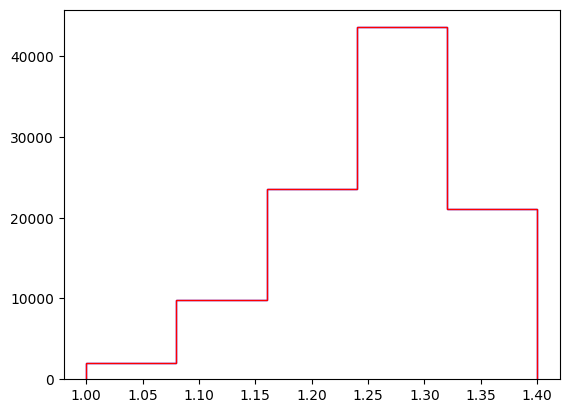

In [16]:
plt.hist(
    df['w'],
    weights=df['FF_weight_BtoDstst0st_BLR_norm'],
    bins=[1.00, 1.08, 1.16, 1.24, 1.32, 1.40],
    histtype='step',
    color='blue'
)
plt.hist(
    df['w'],
    bins=[1.00, 1.08, 1.16, 1.24, 1.32, 1.40],
    histtype='step',
    color='red'
)

plt.show()

In [17]:
df['FF_weight_BtoDstst0st_BLR_norm'].value_counts(dropna=False)

FF_weight_BtoDstst0st_BLR_norm
1.000891    1
1.001763    1
0.999764    1
0.999730    1
1.000476    1
           ..
0.998894    1
0.999405    1
1.000500    1
1.002029    1
1.001550    1
Name: count, Length: 100000, dtype: int64

In [18]:
df['FF_weight_BtoDstst0st_BLR_norm'].min()

0.9967337130798297

In [19]:
df['FF_weight_BtoDstst0st_BLR_norm'].max()

1.0031569599386463